In [69]:
import numpy as np
import pandas as pd
df_sum = pd.read_csv('/Users/xiaozhouye/Desktop/neuefische/Capstone-project_copy/data/summ_scripts.csv')
df_meta = pd.read_csv('/Users/xiaozhouye/Desktop/neuefische/Capstone-project_copy/data/movie_metadata_master.csv')
df_sum.rename(columns={'Id':'imdbid'},inplace=True)
df_sum['imdbid'] = df_sum['imdbid'].astype(int)
df_merged_1 = pd.merge(df_sum,df_meta,how='inner',on='imdbid')
df_merged_1 = df_merged_1[['imdbid','dir','ROI','financial_success']]
df_merged_1['dir']

0       /Users/xiaozhouye/Desktop/neuefische/Capstone-...
1       /Users/xiaozhouye/Desktop/neuefische/Capstone-...
2       /Users/xiaozhouye/Desktop/neuefische/Capstone-...
3       /Users/xiaozhouye/Desktop/neuefische/Capstone-...
4       /Users/xiaozhouye/Desktop/neuefische/Capstone-...
                              ...                        
1022    /Users/xiaozhouye/Desktop/neuefische/Capstone-...
1023    /Users/xiaozhouye/Desktop/neuefische/Capstone-...
1024    /Users/xiaozhouye/Desktop/neuefische/Capstone-...
1025    /Users/xiaozhouye/Desktop/neuefische/Capstone-...
1026    /Users/xiaozhouye/Desktop/neuefische/Capstone-...
Name: dir, Length: 1027, dtype: object

In [70]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import pandas as pd

# Download required NLTK data files
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Initialize a list to store the processed text
processed_texts = []

for file in df_merged_1['dir']:  # Assuming df_merged_1 is a DataFrame with a column 'dir' containing file paths
    with open(file, 'r', encoding='utf-8') as f:
        data = f.read()
        # Remove HTML tags
        data = re.sub(r'<.*?>', '', data)
        # Remove all non-alphabetic characters
        data = re.sub(r'[^a-zA-Z\s]', '', data)
        # Convert to lowercase
        data = data.lower()
        # Tokenization
        words = word_tokenize(data)
        # Remove stop words
        stop_words = set(stopwords.words('english'))
        words = [word for word in words if word not in stop_words]
        # Lemmatization
        lemmatizer = WordNetLemmatizer()
        words = [lemmatizer.lemmatize(word) for word in words]
        # Join words back into a single string
        processed_text = ' '.join(words)
        processed_texts.append(processed_text)

# Add the processed text as a new column in the DataFrame
df_merged_1['text'] = processed_texts

print(df_merged_1.head())



[nltk_data] Downloading package punkt to
[nltk_data]     /Users/xiaozhouye/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/xiaozhouye/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/xiaozhouye/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


    imdbid                                                dir       ROI  \
0  2209418  /Users/xiaozhouye/Desktop/neuefische/Capstone-...  7.747063   
1   401729  /Users/xiaozhouye/Desktop/neuefische/Capstone-...  1.072348   
2    69768  /Users/xiaozhouye/Desktop/neuefische/Capstone-...  4.888889   
3   822847  /Users/xiaozhouye/Desktop/neuefische/Capstone-...  1.402567   
4   130018  /Users/xiaozhouye/Desktop/neuefische/Capstone-...  1.667526   

   financial_success                                               text  
0                  1  midnight screenplay richard linklater ethan ha...  
1                  0  screenplay ehren kruger previous draft mark pr...  
2                  1  working title first draft story outline july a...  
3                  0  written cory goodman pas vale breast steep bea...  
4                  0  written trey callaway bless father sinned beat...  


In [71]:
import numpy as np
import pandas as pd
import os
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score,confusion_matrix

# Download required NLTK data files
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Function to load pre-trained GloVe embeddings
def load_glove_embeddings(glove_file):
    embeddings_index = {}
    with open(glove_file, encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

# Function to preprocess text
def preprocess_text(text):
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove all non-alphabetic characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Convert to lowercase
    text = text.lower()
    # Tokenization
    words = word_tokenize(text)
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(words)

# Function to convert text to GloVe vectors
def texts_to_glove_vectors(texts, embeddings_index):
    text_vectors = []
    for text in texts:
        words = text.split()
        vectors = []
        for word in words:
            vector = embeddings_index.get(word)
            if vector is not None:
                vectors.append(vector)
        if vectors:
            text_vector = np.mean(vectors, axis=0)  # Average word vectors
        else:
            text_vector = np.zeros(embeddings_index[next(iter(embeddings_index))].shape)  # Handle unseen words
        text_vectors.append(text_vector)
    return np.array(text_vectors)

# Example: Load GloVe embeddings
glove_file = '/Users/xiaozhouye/Desktop/neuefische/Capstone-project_copy/ohters/glove.42B.300d.txt'  # Update this path to your GloVe file
glove_embeddings = load_glove_embeddings(glove_file)

# Preprocess text data
df_merged_1['processed_text'] = df_merged_1['text'].apply(preprocess_text)

# Split data into training and testing sets
X = df_merged_1['processed_text']
y = df_merged_1['financial_success']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Vectorize text data using GloVe embeddings
X_train_vec = texts_to_glove_vectors(X_train, glove_embeddings)
X_test_vec = texts_to_glove_vectors(X_test, glove_embeddings)


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/xiaozhouye/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/xiaozhouye/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/xiaozhouye/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [72]:
X_test_vec.shape

(206, 300)

In [73]:
import matplotlib.pyplot as plt
import seaborn as sns
def plot_confusion_matrix(y_true, y_pred, title):
    mat = confusion_matrix(y_true, y_pred)
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
    plt.xlabel('true label')
    plt.ylabel('predicted label')
    plt.title(title)
    plt.show()


##  SVC + glov 

Accuracy: 0.6893203883495146
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        64
           1       0.69      1.00      0.82       142

    accuracy                           0.69       206
   macro avg       0.34      0.50      0.41       206
weighted avg       0.48      0.69      0.56       206



/Users/xiaozhouye/Desktop/neuefische/Capstone-project_copy/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/xiaozhouye/Desktop/neuefische/Capstone-project_copy/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/xiaozhouye/Desktop/neuefische/Capstone-project_copy/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_div

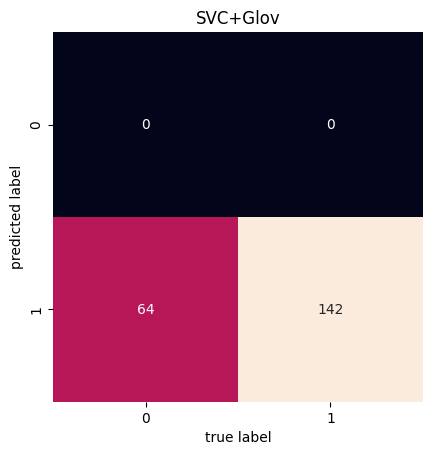

In [74]:
# Initialize and train an SVC model
svc = SVC(kernel='linear')  # Use 'linear' kernel for simplicity
svc.fit(X_train_vec, y_train)

# Predict sentiment on the test set
y_pred = svc.predict(X_test_vec)

# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Classification Report:\n{report}")
plot_confusion_matrix(y_test, y_pred, 'SVC+Glov')

### Random forest

Random Forest Accuracy: 0.6844660194174758
Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.11      0.18        64
           1       0.70      0.94      0.80       142

    accuracy                           0.68       206
   macro avg       0.58      0.53      0.49       206
weighted avg       0.63      0.68      0.61       206



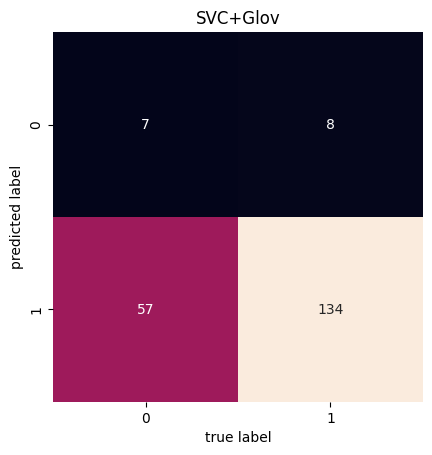

In [75]:
from sklearn.ensemble import RandomForestClassifier

# Initialize and train the Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_vec, y_train)

# Predict sentiment on the test set
y_pred = rf.predict(X_test_vec)

# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Random Forest Accuracy: {accuracy}")
print(f"Random Forest Classification Report:\n{report}")
plot_confusion_matrix(y_test, y_pred, 'SVC+Glov')

### Glov + LogisticRegression

Logistic Regression
Accuracy: 0.6844660194174758
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        64
           1       0.69      0.99      0.81       142

    accuracy                           0.68       206
   macro avg       0.34      0.50      0.41       206
weighted avg       0.47      0.68      0.56       206



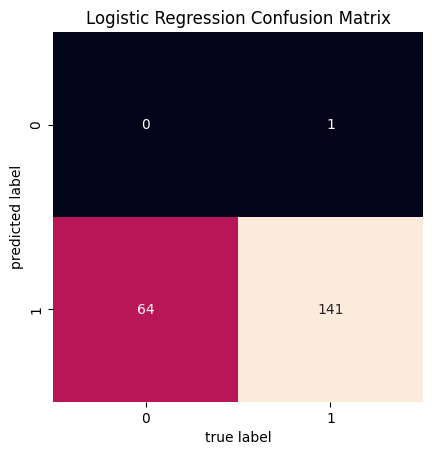

In [76]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_vec, y_train)
y_pred = logreg.predict(X_test_vec)
print("Logistic Regression")
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Classification Report:\n{classification_report(y_test, y_pred)}")
plot_confusion_matrix(y_test, y_pred, "Logistic Regression Confusion Matrix")

### GLov + GradienBoosting

Gradient Boosting
Accuracy: 0.6844660194174758
Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.19      0.27        64
           1       0.71      0.91      0.80       142

    accuracy                           0.68       206
   macro avg       0.60      0.55      0.53       206
weighted avg       0.64      0.68      0.63       206



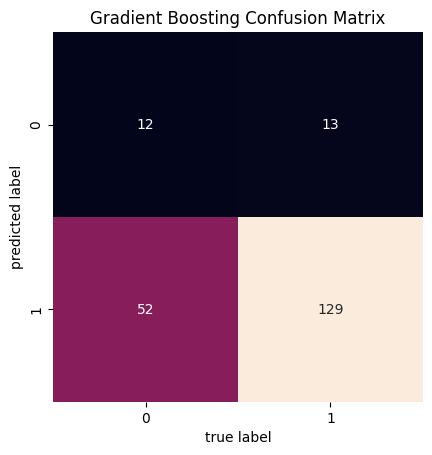

In [77]:
from sklearn.ensemble import  GradientBoostingClassifier
gb = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb.fit(X_train_vec, y_train)
y_pred = gb.predict(X_test_vec)
print("Gradient Boosting")
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Classification Report:\n{classification_report(y_test, y_pred)}")
plot_confusion_matrix(y_test, y_pred, "Gradient Boosting Confusion Matrix")

Weight for class 0: 1.39
Weight for class 1: 0.78
Epoch 1/20
103/103 [==============================] - 0s 2ms/step - loss: 0.6974 - accuracy: 0.4957 - val_loss: 0.6783 - val_accuracy: 0.6990
Epoch 2/20
103/103 [==============================] - 0s 919us/step - loss: 0.6964 - accuracy: 0.5043 - val_loss: 0.7260 - val_accuracy: 0.3107
Epoch 3/20
103/103 [==============================] - 0s 840us/step - loss: 0.6946 - accuracy: 0.5128 - val_loss: 0.6590 - val_accuracy: 0.6845
Epoch 4/20
103/103 [==============================] - 0s 808us/step - loss: 0.6921 - accuracy: 0.5262 - val_loss: 0.7156 - val_accuracy: 0.3544
Epoch 5/20
103/103 [==============================] - 0s 808us/step - loss: 0.6941 - accuracy: 0.5018 - val_loss: 0.6959 - val_accuracy: 0.4757
Epoch 6/20
103/103 [==============================] - 0s 804us/step - loss: 0.6872 - accuracy: 0.5371 - val_loss: 0.6649 - val_accuracy: 0.6650
Epoch 7/20
103/103 [==============================] - 0s 912us/step - loss: 0.6912 - acc

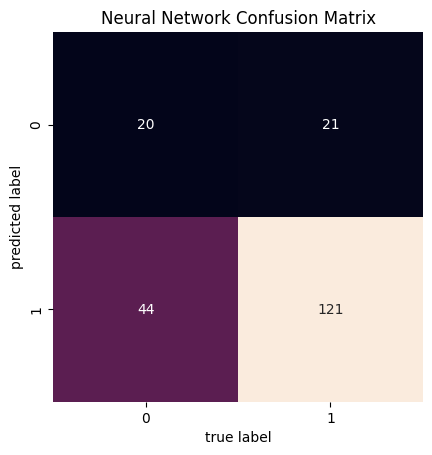

In [78]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
total = len(y_train)
pos = sum(y_train)
neg = total - pos

weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(X_train_vec.shape[1],)))
model.add(Dropout(0.3))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train_vec, y_train, epochs=20, batch_size=8, validation_data=(X_test_vec, y_test), verbose=1,class_weight=class_weight)
loss, accuracy = model.evaluate(X_test_vec, y_test)
print("Neural Network")
print(f"Accuracy: {accuracy}")
y_pred = (model.predict(X_test_vec) > 0.5).astype("int32")
print(f"Classification Report:\n{classification_report(y_test, y_pred)}")
plot_confusion_matrix(y_test, y_pred, "Neural Network Confusion Matrix")